In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [ ]:
batch_size = 64

num_epochs = 50

learning_rate = 3e-4 #.0003

patch_size = 16

In [ ]:
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

In [ ]:
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((img_size + 32, img_size + 32)),
    transforms.RandomCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness by up to 20%
        contrast=0.2,    # Adjust contrast by up to 20%
        saturation=0.2,  # Adjust saturation by up to 20%
        hue=0.0         # Adjust hue by up to 5% (avoiding extreme shifts)
    ),
    transforms.RandAugment(num_ops=2, magnitude=7),  # Applying RandAugment for more random transformations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Mean for R, G, B channels
                         std=[0.229, 0.224, 0.225])   # Standard deviation for R, G, B
])

test_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

In [ ]:
train_data = datasets.Food101(root='./data',
                              split='train',
                              download=True,
                              transform=train_transform)

test_data = datasets.Food101(root='./data',
                             split='test',
                             download=True,
                             transform=test_transform)

validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 68175
Number of validation examples: 7575
Number of testing examples: 25250


In [ ]:
from torch.utils.data import DataLoader

# Set num_workers based on your system
num_workers = min(4, os.cpu_count())

# Training DataLoader (with shuffling)
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True  # Faster data transfer to GPU
)

# Validation DataLoader (no shuffling)
valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation
    num_workers=2,
    pin_memory=True
)

# Test DataLoader (no shuffling)
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,  # Important for consistent evaluation
    num_workers=num_workers,
    pin_memory=True
)

In [ ]:
def extract_patches(img_tensor, patch_size=16):
  bs, c, h, w = img_tensor.size() #get dimensions

  assert h % patch_size == 0 and w % patch_size == 0, \
           f"Image dimensions {h}x{w} must be divisible by patch_size {patch_size}"

  unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
  patches = unfold(img_tensor)
  patches = patches.transpose(1,2)
  return patches

In [ ]:
data_iterator = next(iter(test_loader))

test_img, test_labels = data_iterator

Sequence Length 196


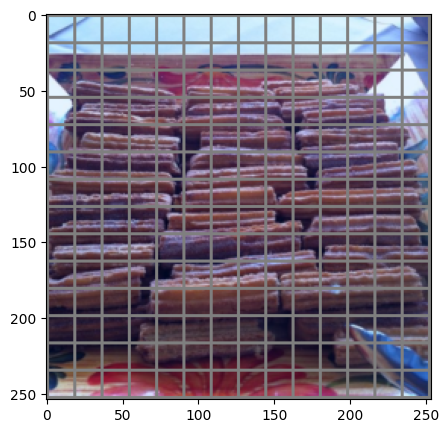

In [ ]:
# Extract patches from the test images using the defined function
patches = extract_patches(test_img, patch_size=patch_size)

patches_square = patches.reshape(test_img.shape[0], -1, 3, patch_size, patch_size)

# Calculate the grid size for visualization
grid_size = test_img.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

# Visualize the patches as a grid
plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches_square[0], grid_size, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, hidden_size=256, num_heads=4):
    super(TransformerBlock, self).__init__()

    self.norm1 = nn.LayerNorm(hidden_size)

    self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                num_heads=num_heads,
                                                batch_first=True,
                                                dropout=0.1)
    self.norm2 = nn.LayerNorm(hidden_size)

    self.mlp = nn.Sequential(
        nn.Linear(hidden_size, hidden_size * 4),  # 4x expansion
        nn.GELU(),  # Standard activation
        nn.Dropout(0.1),  # Regularization
        nn.Linear(hidden_size * 4, hidden_size),
        nn.Dropout(0.1)
    )

  def forward(self, x):
    #apply first norm layer
    norm_x = self.norm1(x)

    #apply multihead attention
    x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x

    #apply second norm lauyer
    norm_x = self.norm2(x)

    x = self.mlp(norm_x) + x
    return x

class ViT(nn.Module):
    def __init__(self, image_size=224, channels_in=3, patch_size=16,
                 hidden_size=384, num_layers=6, num_heads=12):
        super().__init__()

        # Patch embedding
        self.patch_size = patch_size
        self.fc_in = nn.Linear(3 * patch_size**2, hidden_size)  # 3 channels

        # Class token (standard ViT practice)
        self.class_token = nn.Parameter(torch.randn(1, 1, hidden_size))  # Changed from out_vec

        # Positional embeddings (MUST include class token position)
        num_patches = (image_size // patch_size) ** 2
        self.seq_length = num_patches + 1  # +1 for class token
        self.pos_embed = nn.Parameter(torch.randn(1, self.seq_length, hidden_size))

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads)
            for _ in range(num_layers)
        ])

        # Output layer
        self.fc_out = nn.Linear(hidden_size, 101)  # 101 classes for Food101

    def forward(self, x):
        bs = x.shape[0]

        # Extract & embed patches [BS, N, D]
        patches = extract_patches(x, self.patch_size)
        x = self.fc_in(patches)

        # Add class token [BS, N+1, D]
        cls_token = self.class_token.expand(bs, -1, -1)
        x = torch.cat([cls_token, x], dim=1)  # Class token FIRST

        # Add positional embeddings
        x += self.pos_embed  # Now matches dimensions

        # Transformer blocks
        for blk in self.blocks:
            x = blk(x)

        return self.fc_out(x[:, 0])  # Class token output

In [ ]:
# Create a dataloader itterable object
dataiter = next(iter(train_loader))
# Sample from the itterable object
train_images, train_labels = dataiter

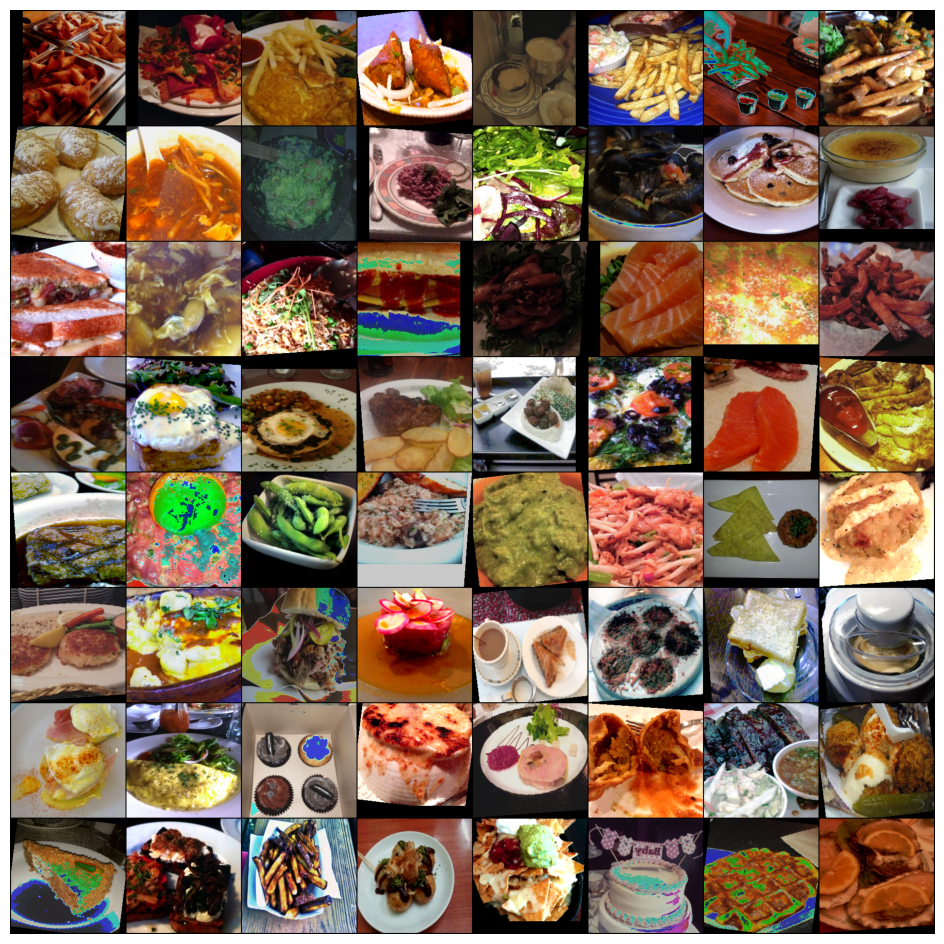

-This Model Has 6591589 (Approximately 6 Million) Parameters!


<ipython-input-43-73c8650d06d0>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


torch.Size([64, 101])

In [ ]:
# Reverse ImageNet normalization for proper visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
denorm_images = train_images * std + mean

plt.figure(figsize=(24, 12))  # Larger for 224x224 images
out = torchvision.utils.make_grid(denorm_images, nrow=8, padding=2)
plt.imshow(out.permute(1, 2, 0))  # Better than numpy().transpose()
plt.axis('off')
plt.show()

model = ViT(
    image_size=224,
    channels_in=3,           # RGB channels
    patch_size=16,           # 16x16 patches (224/16=14 patches per side)
    hidden_size=256,         # Increased from 128 for 101 classes
    num_layers=8,            # 6-12 layers
    num_heads=8             # 384/12=32 dimensions per head
).to(device)

# print(model)

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

# Pass image through network
out = model(test_img.to(device))
# Check output
out.shape

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=num_epochs,
                                                    eta_min=0)
loss_fun = nn.CrossEntropyLoss()

# 2. Try to load checkpoint if it exists
start_epoch = 0
checkpoint_path = 'vit_checkpoint.pth'  # or '/content/drive/MyDrive/vit_checkpoint.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed training from epoch {start_epoch}")
else:
    print("No checkpoint found, starting from scratch.")

Resumed training from epoch 1


In [ ]:
def train(model, optimizer, loader, device, loss_fun, loss_logger):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in tqdm(loader, leave=False, desc="Training"):
        x, y = x.to(device), y.to(device)

        # Mixed precision context
        with autocast():
            fx = model(x)
            loss = loss_fun(fx, y)

        # Scaled backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        running_loss += loss.item()
        _, predicted = fx.max(1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total

    return model, optimizer, epoch_loss, epoch_acc


def evaluate(model, device, loader, loss_fun):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in tqdm(loader, leave=False, desc="Evaluating"):
            x, y = x.to(device), y.to(device)
            fx = model(x)
            loss = loss_fun(fx, y)
            epoch_loss += loss.item()
            _, predicted = fx.max(1)
            correct += (predicted == y.to(device)).sum().item()
            total += y.size(0)

    epoch_loss /= len(loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

best_val_acc = 0.0

# Main Training Loop
training_loss_logger = []
training_acc_logger = []
validation_acc_logger = []
validation_loss_logger = []

pbar = trange(start_epoch, num_epochs, leave=False, desc="Epoch")
for epoch in pbar:
    model, optimizer, train_loss, train_acc = train(
        model=model,
        optimizer=optimizer,
        loader=train_loader,
        device=device,
        loss_fun=loss_fun,
        loss_logger=training_loss_logger
    )

    val_loss, val_acc = evaluate(model=model, device=device, loader=valid_loader, loss_fun=loss_fun)

    training_loss_logger.append(train_loss)
    training_acc_logger.append(train_acc)
    validation_loss_logger.append(val_loss)
    validation_acc_logger.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss
    }, 'vit_checkpoint.pth')
    print(f"Checkpoint saved at epoch {epoch+1}")

    pbar.set_postfix_str(f'Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%')

    # Step the learning rate scheduler
    lr_scheduler.step()

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'vit_best.pth')
        print(f"Best model saved with Val Acc: {val_acc*100:.2f}%")

print("Training Complete")
torch.save(model.state_dict(), 'vit_final.pth')
print("Final model saved as vit_final.pth")


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Training:   0%|          | 0/1066 [00:00<?, ?it/s]

<ipython-input-45-70da9d542dfd>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 3.9001, Train Acc: 11.67% | Val Loss: 3.7661, Val Acc: 14.14%
Checkpoint saved at epoch 2
Best model saved with Val Acc: 14.14%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 3.6398, Train Acc: 15.94% | Val Loss: 3.5376, Val Acc: 17.99%
Checkpoint saved at epoch 3
Best model saved with Val Acc: 17.99%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 3.4322, Train Acc: 19.77% | Val Loss: 3.4215, Val Acc: 20.34%
Checkpoint saved at epoch 4
Best model saved with Val Acc: 20.34%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 3.2587, Train Acc: 22.91% | Val Loss: 3.2325, Val Acc: 23.49%
Checkpoint saved at epoch 5
Best model saved with Val Acc: 23.49%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 3.1142, Train Acc: 25.60% | Val Loss: 3.0868, Val Acc: 26.35%
Checkpoint saved at epoch 6
Best model saved with Val Acc: 26.35%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 2.9827, Train Acc: 28.27% | Val Loss: 2.9645, Val Acc: 28.42%
Checkpoint saved at epoch 7
Best model saved with Val Acc: 28.42%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 2.8687, Train Acc: 30.56% | Val Loss: 2.9031, Val Acc: 30.48%
Checkpoint saved at epoch 8
Best model saved with Val Acc: 30.48%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 2.7693, Train Acc: 32.70% | Val Loss: 2.8162, Val Acc: 31.43%
Checkpoint saved at epoch 9
Best model saved with Val Acc: 31.43%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 2.6708, Train Acc: 34.37% | Val Loss: 2.7571, Val Acc: 33.28%
Checkpoint saved at epoch 10
Best model saved with Val Acc: 33.28%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 2.5863, Train Acc: 36.34% | Val Loss: 2.7330, Val Acc: 34.10%
Checkpoint saved at epoch 11
Best model saved with Val Acc: 34.10%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 2.4997, Train Acc: 37.99% | Val Loss: 2.6541, Val Acc: 36.34%
Checkpoint saved at epoch 12
Best model saved with Val Acc: 36.34%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 2.4095, Train Acc: 39.64% | Val Loss: 2.6243, Val Acc: 36.78%
Checkpoint saved at epoch 13
Best model saved with Val Acc: 36.78%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 2.3231, Train Acc: 41.70% | Val Loss: 2.5699, Val Acc: 37.73%
Checkpoint saved at epoch 14
Best model saved with Val Acc: 37.73%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 2.2435, Train Acc: 43.19% | Val Loss: 2.5282, Val Acc: 38.42%
Checkpoint saved at epoch 15
Best model saved with Val Acc: 38.42%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 2.1654, Train Acc: 44.98% | Val Loss: 2.5040, Val Acc: 39.18%
Checkpoint saved at epoch 16
Best model saved with Val Acc: 39.18%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 2.0954, Train Acc: 46.56% | Val Loss: 2.4587, Val Acc: 40.17%
Checkpoint saved at epoch 17
Best model saved with Val Acc: 40.17%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 2.0225, Train Acc: 47.91% | Val Loss: 2.4573, Val Acc: 40.16%
Checkpoint saved at epoch 18


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 1.9489, Train Acc: 49.45% | Val Loss: 2.4208, Val Acc: 40.66%
Checkpoint saved at epoch 19
Best model saved with Val Acc: 40.66%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 1.8720, Train Acc: 51.29% | Val Loss: 2.3914, Val Acc: 42.30%
Checkpoint saved at epoch 20
Best model saved with Val Acc: 42.30%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 1.8082, Train Acc: 52.63% | Val Loss: 2.3748, Val Acc: 42.56%
Checkpoint saved at epoch 21
Best model saved with Val Acc: 42.56%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 1.7356, Train Acc: 54.50% | Val Loss: 2.3745, Val Acc: 42.44%
Checkpoint saved at epoch 22


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 1.6588, Train Acc: 56.04% | Val Loss: 2.3198, Val Acc: 44.30%
Checkpoint saved at epoch 23
Best model saved with Val Acc: 44.30%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 1.5954, Train Acc: 57.33% | Val Loss: 2.3263, Val Acc: 44.50%
Checkpoint saved at epoch 24
Best model saved with Val Acc: 44.50%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 1.5215, Train Acc: 59.33% | Val Loss: 2.3092, Val Acc: 44.84%
Checkpoint saved at epoch 25
Best model saved with Val Acc: 44.84%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 1.4700, Train Acc: 60.47% | Val Loss: 2.3174, Val Acc: 44.71%
Checkpoint saved at epoch 26


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 1.4057, Train Acc: 62.20% | Val Loss: 2.3123, Val Acc: 45.36%
Checkpoint saved at epoch 27
Best model saved with Val Acc: 45.36%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 1.3461, Train Acc: 63.32% | Val Loss: 2.2940, Val Acc: 45.49%
Checkpoint saved at epoch 28
Best model saved with Val Acc: 45.49%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 1.2877, Train Acc: 64.99% | Val Loss: 2.2897, Val Acc: 46.39%
Checkpoint saved at epoch 29
Best model saved with Val Acc: 46.39%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 1.2317, Train Acc: 66.43% | Val Loss: 2.2870, Val Acc: 46.39%
Checkpoint saved at epoch 30


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 1.1813, Train Acc: 67.78% | Val Loss: 2.3086, Val Acc: 46.44%
Checkpoint saved at epoch 31
Best model saved with Val Acc: 46.44%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 1.1252, Train Acc: 69.01% | Val Loss: 2.3368, Val Acc: 46.31%
Checkpoint saved at epoch 32


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 1.0695, Train Acc: 70.54% | Val Loss: 2.3681, Val Acc: 46.05%
Checkpoint saved at epoch 33


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 1.0305, Train Acc: 71.71% | Val Loss: 2.3230, Val Acc: 46.88%
Checkpoint saved at epoch 34
Best model saved with Val Acc: 46.88%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 35/50 - Train Loss: 0.9861, Train Acc: 72.77% | Val Loss: 2.3300, Val Acc: 47.08%
Checkpoint saved at epoch 35
Best model saved with Val Acc: 47.08%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 0.9469, Train Acc: 73.86% | Val Loss: 2.3333, Val Acc: 46.83%
Checkpoint saved at epoch 36


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 0.9078, Train Acc: 74.84% | Val Loss: 2.3217, Val Acc: 47.59%
Checkpoint saved at epoch 37
Best model saved with Val Acc: 47.59%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 0.8793, Train Acc: 75.67% | Val Loss: 2.3294, Val Acc: 47.92%
Checkpoint saved at epoch 38
Best model saved with Val Acc: 47.92%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 0.8449, Train Acc: 76.54% | Val Loss: 2.3222, Val Acc: 47.82%
Checkpoint saved at epoch 39


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.8084, Train Acc: 77.82% | Val Loss: 2.3309, Val Acc: 48.24%
Checkpoint saved at epoch 40
Best model saved with Val Acc: 48.24%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 41/50 - Train Loss: 0.7858, Train Acc: 78.33% | Val Loss: 2.3463, Val Acc: 47.59%
Checkpoint saved at epoch 41


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 0.7618, Train Acc: 78.99% | Val Loss: 2.3499, Val Acc: 48.48%
Checkpoint saved at epoch 42
Best model saved with Val Acc: 48.48%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 0.7434, Train Acc: 79.48% | Val Loss: 2.3425, Val Acc: 48.91%
Checkpoint saved at epoch 43
Best model saved with Val Acc: 48.91%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 0.7247, Train Acc: 80.06% | Val Loss: 2.3621, Val Acc: 48.36%
Checkpoint saved at epoch 44


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 0.7149, Train Acc: 80.48% | Val Loss: 2.3509, Val Acc: 48.12%
Checkpoint saved at epoch 45


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 0.7058, Train Acc: 80.64% | Val Loss: 2.3181, Val Acc: 49.31%
Checkpoint saved at epoch 46
Best model saved with Val Acc: 49.31%


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 0.6862, Train Acc: 81.17% | Val Loss: 2.3624, Val Acc: 48.20%
Checkpoint saved at epoch 47


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 0.6822, Train Acc: 81.26% | Val Loss: 2.3349, Val Acc: 48.87%
Checkpoint saved at epoch 48


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 0.6799, Train Acc: 81.40% | Val Loss: 2.3333, Val Acc: 48.74%
Checkpoint saved at epoch 49


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.6765, Train Acc: 81.53% | Val Loss: 2.3118, Val Acc: 48.98%
Checkpoint saved at epoch 50
Training Complete
Final model saved as vit_final.pth


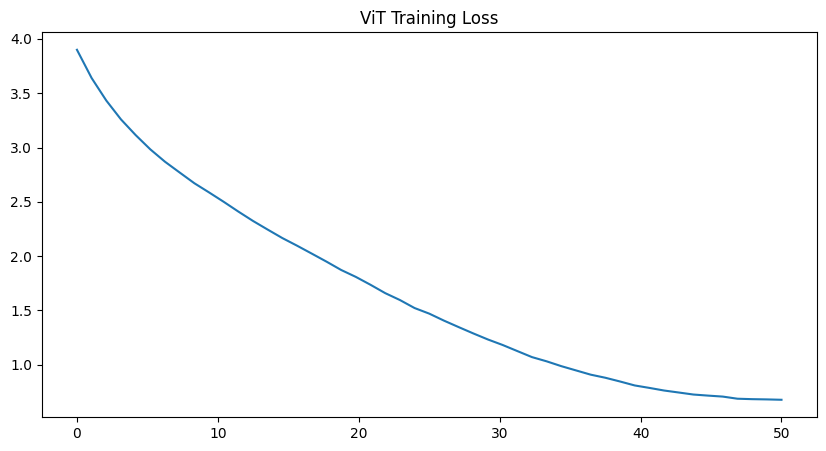

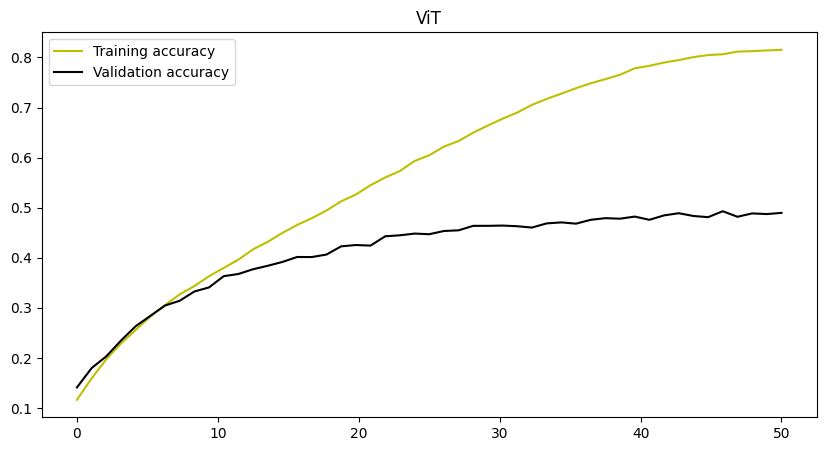

In [ ]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
_ = plt.title("ViT Training Loss")
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("ViT")
_ = plt.legend(["Training accuracy", "Validation accuracy"])